1. Import Libraries 

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier

2. EDA

In [29]:
# Load CSV-Data
df = pd.read_csv("data/kickstarter_projects.csv")

# Explore the data
df.head()
df.info()
df.describe()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374853 entries, 0 to 374852
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   ID           374853 non-null  int64 
 1   Name         374853 non-null  object
 2   Category     374853 non-null  object
 3   Subcategory  374853 non-null  object
 4   Country      374853 non-null  object
 5   Launched     374853 non-null  object
 6   Deadline     374853 non-null  object
 7   Goal         374853 non-null  int64 
 8   Pledged      374853 non-null  int64 
 9   Backers      374853 non-null  int64 
 10  State        374853 non-null  object
dtypes: int64(4), object(7)
memory usage: 31.5+ MB


ID             0
Name           0
Category       0
Subcategory    0
Country        0
Launched       0
Deadline       0
Goal           0
Pledged        0
Backers        0
State          0
dtype: int64

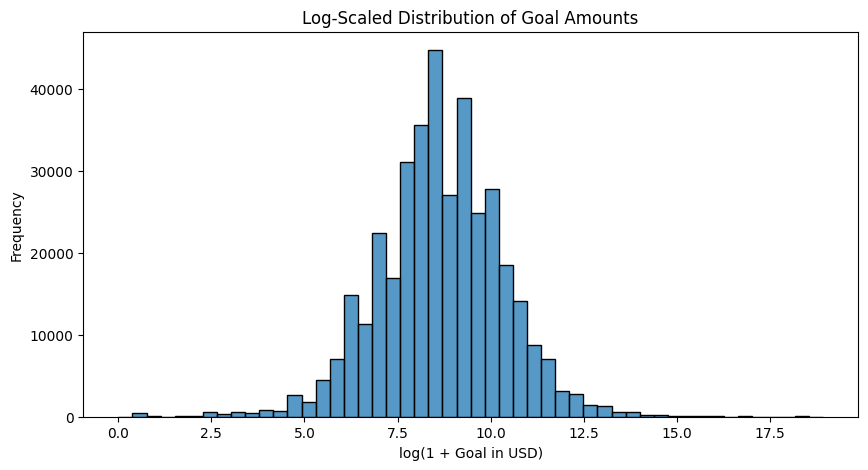

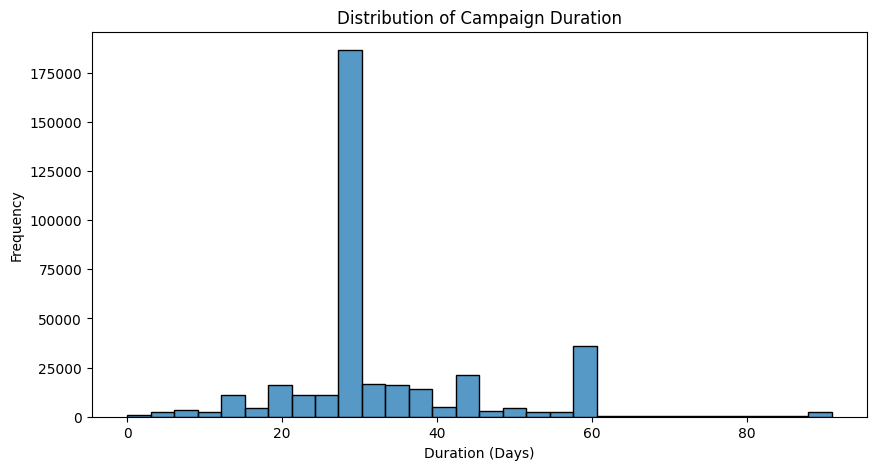

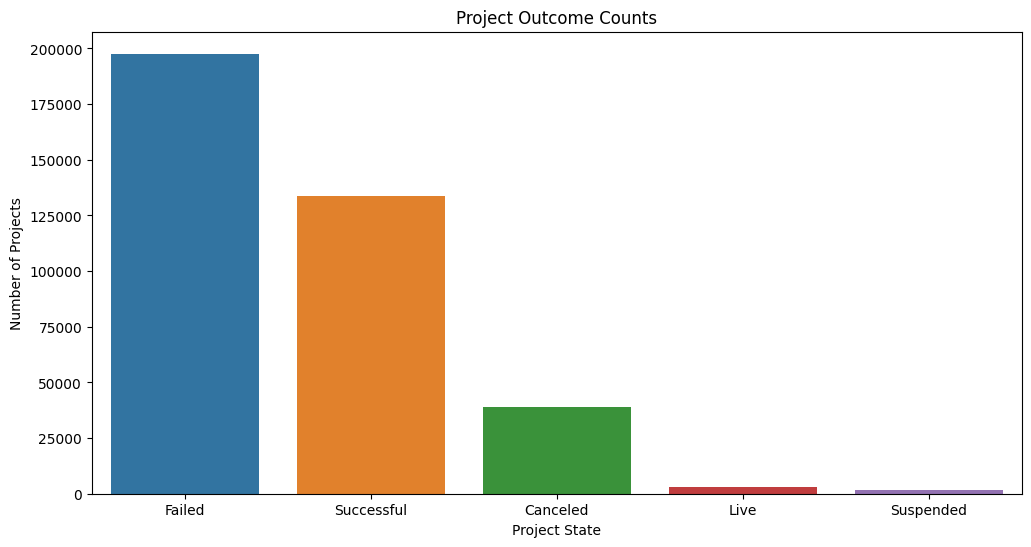

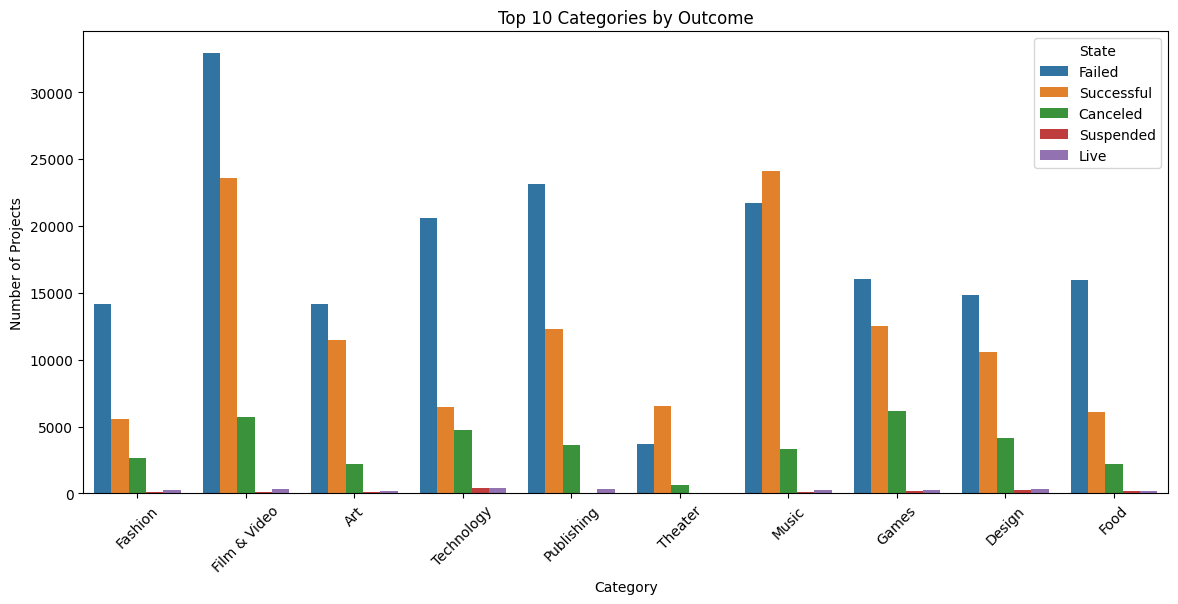

In [30]:
# droop 'Backers' and 'Pledged'
df_clean = df.drop(columns=['Backers', 'Pledged'])

# convert to datetime
df_clean['Launched'] = pd.to_datetime(df_clean['Launched'])
df_clean['Deadline'] = pd.to_datetime(df_clean['Deadline'])

# duration in days
df_clean['Duration'] = (df_clean['Deadline'] - df_clean['Launched']).dt.days

# statistics for all columns
summary_stats = df_clean.describe(include='all')

# visualize the data
plt.figure(figsize=(10, 5))
sns.histplot(np.log1p(df_clean['Goal']), bins=50, kde=False)
plt.title('Log-Scaled Distribution of Goal Amounts')
plt.xlabel('log(1 + Goal in USD)')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(df_clean['Duration'], bins=30, kde=False)
plt.title('Distribution of Campaign Duration')
plt.xlabel('Duration (Days)')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(12, 6))
sns.countplot(x='State', data=df_clean, order=df_clean['State'].value_counts().index)
plt.title('Project Outcome Counts')
plt.xlabel('Project State')
plt.ylabel('Number of Projects')
plt.show()

plt.figure(figsize=(14, 6))
top_categories = df_clean['Category'].value_counts().nlargest(10).index
sns.countplot(data=df_clean[df_clean['Category'].isin(top_categories)], x='Category', hue='State')
plt.title('Top 10 Categories by Outcome')
plt.xticks(rotation=45)
plt.ylabel('Number of Projects')
plt.show()


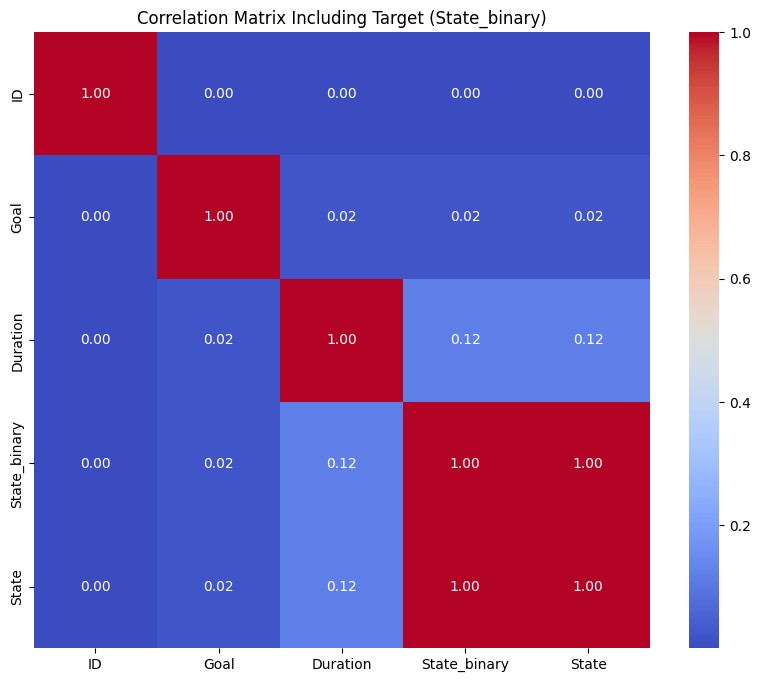

In [31]:
# remove rows with "suspended" or "live"
df_filtered = df_clean[~df_clean['State'].str.lower().isin(['suspended', 'live'])].copy()

# target variable encoding  
df_filtered['State_binary'] = df_filtered['State'].apply(lambda x: 0 if x == 'Successful' else 1)

# correlation matrix for numeric features
numeric_features = df_filtered.select_dtypes(include=['float64', 'int64'])

# correlation matrix including the target column
correlation_matrix = numeric_features.assign(State=df_filtered['State_binary']).corr()

# visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix Including Target (State_binary)')
plt.show()

In [32]:
# Feature Engineering
# Create new features based on existing ones
categorical_cols = ['Category', 'Subcategory', 'Country']

# One-hot encoding for categorical features
df_encoded = pd.get_dummies(df_filtered, columns=categorical_cols, drop_first=True)

df_encoded.head()


,ID,Name,Launched,Deadline,Goal,State,Duration,State_binary,Category_Comics,Category_Crafts,...,Country_Mexico,Country_Netherlands,Country_New Zealand,Country_Norway,Country_Singapore,Country_Spain,Country_Sweden,Country_Switzerland,Country_United Kingdom,Country_United States
0,1860890148,Grace Jones Does Not Give A F$#% T-Shirt (limi...,2009-04-21 21:02:48,2009-05-31,1000,Failed,39,1,False,False,...,False,False,False,False,False,False,False,False,False,True
1,709707365,CRYSTAL ANTLERS UNTITLED MOVIE,2009-04-23 00:07:53,2009-07-20,80000,Failed,87,1,False,False,...,False,False,False,False,False,False,False,False,False,True
2,1703704063,drawing for dollars,2009-04-24 21:52:03,2009-05-03,20,Successful,8,0,False,False,...,False,False,False,False,False,False,False,False,False,True
3,727286,Offline Wikipedia iPhone app,2009-04-25 17:36:21,2009-07-14,99,Successful,79,0,False,False,...,False,False,False,False,False,False,False,False,False,True
4,1622952265,Pantshirts,2009-04-27 14:10:39,2009-05-26,1900,Failed,28,1,False,False,...,False,False,False,False,False,False,False,False,False,True


3. Baseline Model

In [33]:

# one-hot-encoding 
df_model = pd.get_dummies(df_filtered, columns=['Category'], drop_first=True)

# features & target
X = df_model.drop(columns=['ID', 'Name', 'Launched', 'Deadline', 'State', 'State_binary',
                           'Subcategory', 'Country']) 
y = df_model['State_binary']

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# train modell 
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# evaluate model
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6384533311724269

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00     26770
           1       0.64      1.00      0.78     47273

    accuracy                           0.64     74043
   macro avg       0.32      0.50      0.39     74043
weighted avg       0.41      0.64      0.50     74043



c:\Users\thear\Neue Fische c\kickstart_ml\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\thear\Neue Fische c\kickstart_ml\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\thear\Neue Fische c\kickstart_ml\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

In [34]:
# one-hot-encoding 
df_model = pd.get_dummies(df_filtered, columns=['Category'], drop_first=True)

# features & target
X = df_model.drop(columns=['ID', 'Name', 'Launched', 'Deadline', 'State', 'State_binary',
                           'Subcategory', 'Country'])
y = df_model['State_binary']

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# trian model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# evaluate model
y_pred = rf_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6488526937050092

Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.41      0.46     26770
           1       0.70      0.78      0.74     47273

    accuracy                           0.65     74043
   macro avg       0.61      0.60      0.60     74043
weighted avg       0.63      0.65      0.64     74043

